In [38]:
from typing import Dict, Tuple

import numpy as np
import pandas as pd
from postprocess.lps_plots import sel_evaluation_domain
from products.plot_settings import MF_SYNOPSIS_VAR_NAME, NASA_L3_JPSS1_VAR_NAME, NASA_L3_SNPP_VAR_NAME,MF_NO_FOREST_RED_BAND_SCREEEN_VAR_NAME
from reductions.statistics_base import EvaluationVsHighResBase
from winter_year import WinterYear
import xarray as xr
from xarray.groupers import BinGrouper

wy = WinterYear(2023, 2024)
analysis_folder = (
    "/home/imperatoren/work/VIIRS_S2_comparison/viirsnow/output_folder/version_6_lps/analyses/"
)
analysis_type = "confusion_table"

analyses_dict_confusion = {
    MF_NO_FOREST_RED_BAND_SCREEEN_VAR_NAME: xr.open_dataset(
        f"{analysis_folder}/{analysis_type}/{analysis_type}_WY_2023_2024_meteofrance_no_forest_red_band_screen_vs_s2_theia.nc",
        decode_cf=True,
    ),
    NASA_L3_SNPP_VAR_NAME: xr.open_dataset(
        f"{analysis_folder}/{analysis_type}/{analysis_type}_WY_2023_2024_nasa_l3_snpp_vs_s2_theia.nc", decode_cf=True
    ),
    NASA_L3_JPSS1_VAR_NAME: xr.open_dataset(
        f"{analysis_folder}/{analysis_type}/{analysis_type}_WY_2023_2024_nasa_l3_jpss1_vs_s2_theia.nc",
        decode_cf=True,
    ),
}

analysis_type = "uncertainty"

analyses_dict_uncertainty = {
    MF_NO_FOREST_RED_BAND_SCREEEN_VAR_NAME: xr.open_dataset(
        f"{analysis_folder}/{analysis_type}/{analysis_type}_WY_2023_2024_meteofrance_no_forest_red_band_screen_vs_s2_theia.nc",
        decode_cf=True,
    ),
    NASA_L3_SNPP_VAR_NAME: xr.open_dataset(
        f"{analysis_folder}/{analysis_type}/{analysis_type}_WY_2023_2024_nasa_l3_snpp_vs_s2_theia.nc", decode_cf=True
    ),
    NASA_L3_JPSS1_VAR_NAME: xr.open_dataset(
        f"{analysis_folder}/{analysis_type}/{analysis_type}_WY_2023_2024_nasa_l3_jpss1_vs_s2_theia.nc",
        decode_cf=True,
    ),
}

def sel_evaluation_domain(analyses_dict: Dict[str, xr.Dataset]) ->Dict[str, xr.Dataset]:

    selection_dict={}
    for k, v in analyses_dict.items():
        if 'sensor_zenith_bins' not in v.sizes:
            selection_dict .update({
                k: v.expand_dims({'sensor_zenith_bins': 5})
                })
        else:
            selection_dict.update({k:v})

    selection_dict = {
        k: v.sel(
            time=slice("2023-12", "2024-06"),
            altitude_bins=slice(900, None),
            ref_bins=slice(0, 101),
            slope_bins=slice(None, 60),
            sensor_zenith_bins=slice(None,80)
        )
        for k, v in selection_dict.items()
    }

    selection_dict = {
        k: v.assign_coords(
            {
                "aspect_bins": pd.CategoricalIndex(
                    data=EvaluationVsHighResBase.aspect_bins().labels,
                    categories=EvaluationVsHighResBase.aspect_bins().labels,
                    ordered=True,
                ),
                "forest_mask_bins": ["Open", "Forest"],
                "slope_bins": np.array(["[0-10]", "[11-30]", ">30"], dtype=str),
                "sensor_zenith_bins": np.array(["[0-15]", "[15-30]", "[30-45]", "[45-60]",">60"], dtype=str),
            }
        )
        for k, v in selection_dict.items()
    }

    selection_dict = {
        k: v.rename(
            {"aspect_bins": "Aspect", "forest_mask_bins": "Landcover", "slope_bins": "Slope [°]", "sensor_zenith_bins": "View Zenith Angle [°]"}
        )
        for k, v in selection_dict.items()
    }

    return selection_dict



metrics_dict_conf = sel_evaluation_domain(analyses_dict=analyses_dict_confusion)
metrics_dict_conf = {k:v.groupby(ref_bins=BinGrouper(bins=[-1,0,99,100], labels=["0", "[1-99]", "100"])).sum().rename({"ref_bins_bins": "Ref FSC [%]"}) for k,v in metrics_dict_conf.items()}
metrics_dict_unc = sel_evaluation_domain(analyses_dict=analyses_dict_uncertainty)
metrics_dict_unc = {k:v.sum(dim=( 'time')).assign_coords(ref_bins=["0", "[1-25]", "[26-50]","[51-75]", "[75-99]", "100"]).rename({"ref_bins": "Ref FSC [%]"}) for k,v in metrics_dict_unc.items()}

/home/imperatoren/miniconda3/envs/viirs_env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Noto Sans.
  fig.canvas.print_figure(bytes_io, **kw)


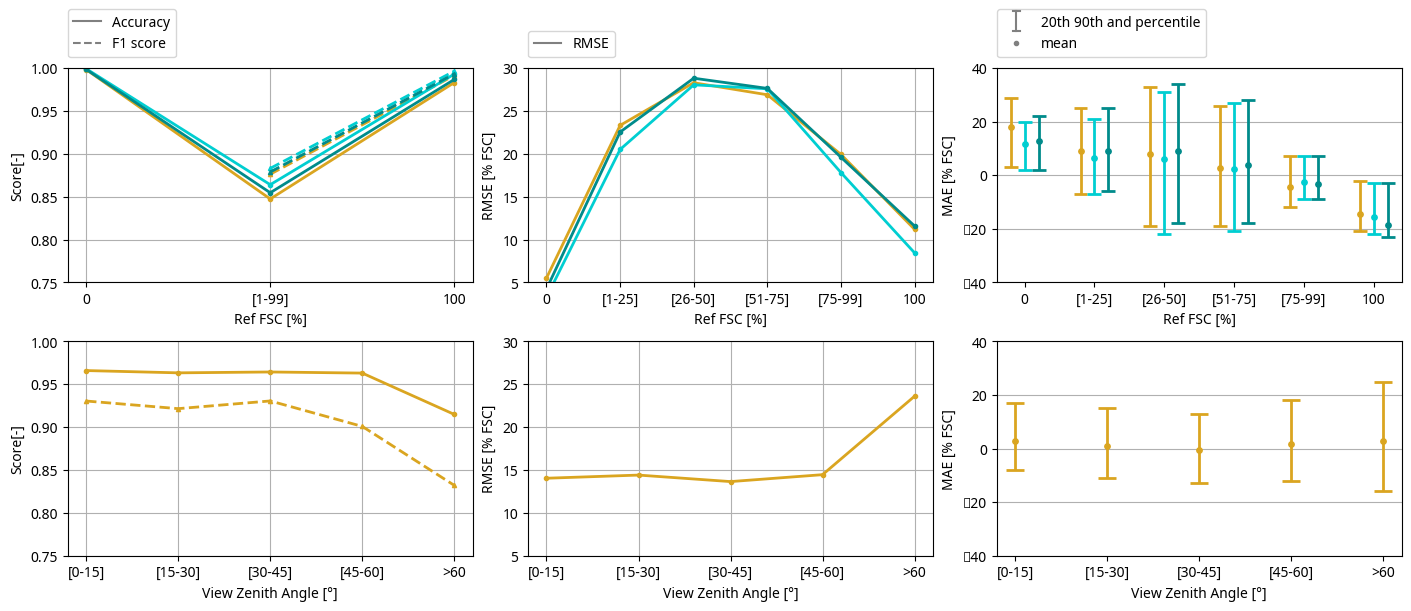

/tmp/ipykernel_61936/3116206069.py:134: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Noto Sans.
  fig.savefig('/home/imperatoren/work/VIIRS_S2_comparison/lps/poster/illustrations/evaluation_multiplot_ref_fsc_vza.png', format='png')


In [53]:
from typing import List
from matplotlib import pyplot as plt
from matplotlib.axes import Axes
from matplotlib.figure import Figure
from matplotlib.lines import Line2D
from postprocess.error_distribution import histograms_to_biais_rmse, histograms_to_distribution, postprocess_uncertainty_analysis
from postprocess.lps_plots import HandlerPoint, HandlerSpan, compute_skill_scores_for_parameter, plot_custom_spans, plot_synthesis, smooth_data_np_convolve
from products.plot_settings import PRODUCT_PLOT_COLORS, PRODUCT_PLOT_NAMES
import matplotlib.patches as mpatches


def plot_custom_spans(metrics_dict: Dict[str, xr.Dataset], analysis_var: str, ax: plt.Axes):
    x_positions = np.arange(len(list(metrics_dict.values())[0].coords[analysis_var].values))
    x_positions = x_positions / len(x_positions)
    ax.set_ylim(-40, 40)
    for product_name, metrics_dataset in metrics_dict.items():
        color = PRODUCT_PLOT_COLORS[product_name]
        analysis_coords = metrics_dict[product_name].coords[analysis_var].values
        box_width_data = 0.2 / len(x_positions)
        for idx, value in enumerate(analysis_coords):
            x_pos = x_positions[idx]
            product_analysis_var_dataset = metrics_dataset.sel({analysis_var: value}).drop_sel(biais_bins=0)
            reduced = product_analysis_var_dataset.groupby("biais_bins").sum(list(product_analysis_var_dataset.sizes.keys()))
            smooth = smooth_data_np_convolve(reduced.data_vars["n_occurrences"], 1)
            smooth = smooth / smooth.max()

            biais_rmse = histograms_to_biais_rmse(reduced)
            distr = histograms_to_distribution(reduced)
            ax.scatter(x_pos, biais_rmse.data_vars["biais"], marker="o", color=color, s=15, zorder=3)

            whiskers_min = np.quantile(distr, 0.20)
            whiskers_max = np.quantile(distr, 0.80)
            ax.vlines(x_pos, whiskers_min, whiskers_max, color=color, linestyle="-", lw=2, label=product_name)

            ax.hlines(whiskers_min, x_pos - box_width_data / 2, x_pos + box_width_data / 2, color=color, lw=2)
            ax.hlines(whiskers_max, x_pos - box_width_data / 2, x_pos + box_width_data / 2, color=color, lw=2)
        x_positions = x_positions + box_width_data

    ax.set_xticks(x_positions - box_width_data * ((len(metrics_dict) + 1) // 2), labels=analysis_coords)
    ax.set_xlim(x_positions[0] - (len(metrics_dict) + 1) * box_width_data, x_positions[-1])
    ax.set_ylabel(f"MAE [% FSC]")
    ax.set_xlabel(analysis_var)

def plot_synthesis(metrics_dict_conf: Dict[str, xr.Dataset], metrics_dict_unc: Dict[str, xr.Dataset], params_list: List[str], axs: List[Axes] | None  = None):
    if axs is None:
        _, axs = plt.subplots(len(params), 3, figsize=(12, 3 * len(params)), layout="constrained")
    custom_leg = [
        mpatches.Patch(color=PRODUCT_PLOT_COLORS[product_name], label=PRODUCT_PLOT_NAMES[product_name])
        for product_name in metrics_dict_unc
    ]
    
    # for i in range(len(metrics_dict_unc)-1):
    #     for j in range(3):
    #         product_legend =axs[i, j].legend(handles=custom_leg, loc='best')
    #         axs[i, j].add_artist(product_legend)
    axs[0, 0].legend(
        [Line2D([0], [0], linestyle="-", color="gray"), Line2D([0], [0], linestyle="--", color="gray")],
        ["Accuracy", "F1 score"],
        loc=(0, 1.05),
    )
    axs[0, 1].legend([Line2D([0], [0], linestyle="-", color="gray")], ["RMSE"], loc=(0, 1.05))

    (l1,) = axs[0, 2].plot([0, 1], [0, 1], c="gray", lw=1e-12)
    (l2,) = axs[0, 2].plot(0, 0, c="gray", markersize=1e-12)
    axs[0, 2].legend(
        [l1, l2], ["20th 90th and percentile", "mean"], handler_map={l1: HandlerSpan(), l2: HandlerPoint()}, loc=(0, 1.05)
    )
    for i, var in enumerate(params_list):
        skill_scores = compute_skill_scores_for_parameter(metrics_dict_conf, variable=var)
        skill_scores = skill_scores.where(skill_scores != 0, np.nan)
        biais_rmse = postprocess_uncertainty_analysis(metrics_dict_unc, analysis_var=var)

        axs[i, 0].set_ylim(0.75, 1)
        axs[i, 0].set_ylabel("Score[-]")
        axs[i, 0].set_xlabel(var)
        axs[i, 0].grid(True)
        axs[i, 1].set_ylim(5, 30)
        axs[i, 1].set_ylabel("RMSE [% FSC]")
        axs[i, 1].set_xlabel(var)
        axs[i, 1].grid(True)
        if var == "View Zenith Angle [°]" :
            plot_custom_spans(metrics_dict={MF_NO_FOREST_RED_BAND_SCREEEN_VAR_NAME:metrics_dict_unc[MF_NO_FOREST_RED_BAND_SCREEEN_VAR_NAME]}, analysis_var=var, ax=axs[i, 2])
        else:
             plot_custom_spans(metrics_dict=metrics_dict_unc, analysis_var=var, ax=axs[i, 2])
        axs[i, 2].grid(axis="y")

        for prod in metrics_dict_conf:
            #     # print(skill_scores.loc[PRODUCT_PLOT_NAMES[prod]])
            x_coords_conf = metrics_dict_conf[list(metrics_dict_conf.keys())[0]].coords[var].values
            x_coords_unc = metrics_dict_unc[list(metrics_dict_unc.keys())[0]].coords[var].values
            if var == "View Zenith Angle [°]" :
                if prod in (NASA_L3_JPSS1_VAR_NAME, NASA_L3_SNPP_VAR_NAME):
                    continue

            if var in ("Ref FSC [%]", "Slope [°]","View Zenith Angle [°]"):
                skill_scores = skill_scores.sel({var: x_coords_conf})
                biais_rmse = biais_rmse.sel({var: x_coords_unc})

            axs[i, 0].plot(
                x_coords_conf,
                skill_scores.sel(product=PRODUCT_PLOT_NAMES[prod]).data_vars["accuracy"],
                "-o",
                color=PRODUCT_PLOT_COLORS[prod],
                markersize=3,
                lw=2
            )
            axs[i, 0].plot(
                x_coords_conf,
                skill_scores.sel(product=PRODUCT_PLOT_NAMES[prod]).data_vars["f1_score"],
                "--^",
                color=PRODUCT_PLOT_COLORS[prod],
                markersize=3,
                lw=2
            )
            axs[i, 1].plot(
                x_coords_unc,
                biais_rmse.data_vars["rmse"].sel(product=prod),
                "-o",
                color=PRODUCT_PLOT_COLORS[prod],
                markersize=3,
                lw=2
            )

    plt.show()


params = ["Ref FSC [%]", "View Zenith Angle [°]"] 
fig, axs = plt.subplots(len(params), 3, figsize=(14,3  * len(params)), layout="constrained")
plt.style.use('default')
plt.rcParams["font.family"] = "Noto Sans"
plot_synthesis(metrics_dict_conf, metrics_dict_unc, params_list=params, axs=axs)
# [ax.grid(True) for ax in axs]
fig.patch.set_alpha(0.0)
fig.savefig('/home/imperatoren/work/VIIRS_S2_comparison/lps/poster/illustrations/evaluation_multiplot_ref_fsc_vza.png', format='png')

In [34]:
from typing import Dict

import numpy as np

from products.plot_settings import NASA_L3_MULTIPLATFORM_VAR_NAME, PRODUCT_PLOT_COLORS, NASA_L3_JPSS1_VAR_NAME, NASA_L3_SNPP_VAR_NAME, MF_NO_FOREST_RED_BAND_SCREEEN_VAR_NAME
import xarray as xr
from matplotlib import pyplot as plt
from postprocess.error_distribution import histograms_to_biais_rmse

analysis_type = "completeness"
analysis_folder = (
    "/home/imperatoren/work/VIIRS_S2_comparison/viirsnow/output_folder/version_6_lps/analyses/"
)
analyses_dict_completeness = {
    # MF_NO_FOREST_RED_BAND_SCREEEN_VAR_NAME: xr.open_dataset(
    #     f"{analysis_folder}/{analysis_type}/{analysis_type}_WY_2023_2024_meteofrance_no_forest_red_band_screen.nc",
    #     decode_cf=True,
    # ),

    NASA_L3_SNPP_VAR_NAME: xr.open_dataset(
        f"{analysis_folder}/{analysis_type}/{analysis_type}_WY_2023_2024_nasa_l3_snpp.nc", decode_cf=True
    ),
    NASA_L3_JPSS1_VAR_NAME: xr.open_dataset(
        f"{analysis_folder}/{analysis_type}/{analysis_type}_WY_2023_2024_nasa_l3_jpss1.nc",
        decode_cf=True,
    ),
    NASA_L3_MULTIPLATFORM_VAR_NAME: xr.open_dataset(
        f"{analysis_folder}/{analysis_type}/{analysis_type}_WY_2023_2024_nasa_l3_multiplatform.nc",
        decode_cf=True,
    ),

}

metrics_dict_completeness = {k:v.sel(time=slice('2023-11', '2024-06')) for k,v in analyses_dict_completeness.items()}

analysis_type = "uncertainty"

analyses_dict_uncertainty = {
    MF_NO_FOREST_RED_BAND_SCREEEN_VAR_NAME: xr.open_dataset(
        f"{analysis_folder}/{analysis_type}/{analysis_type}_WY_2023_2024_meteofrance_no_forest_red_band_screen_vs_s2_theia.nc",
        decode_cf=True,
    ),
    NASA_L3_SNPP_VAR_NAME: xr.open_dataset(
        f"{analysis_folder}/{analysis_type}/{analysis_type}_WY_2023_2024_nasa_l3_snpp_vs_s2_theia.nc", decode_cf=True
    ),
    NASA_L3_JPSS1_VAR_NAME: xr.open_dataset(
        f"{analysis_folder}/{analysis_type}/{analysis_type}_WY_2023_2024_nasa_l3_jpss1_vs_s2_theia.nc",
        decode_cf=True,
    ),
    NASA_L3_MULTIPLATFORM_VAR_NAME: xr.open_dataset(
        f"{analysis_folder}/{analysis_type}/{analysis_type}_WY_2023_2024_nasa_l3_multiplatform_vs_s2_theia.nc",
        decode_cf=True,
    ),
}

metrics_dict_unc = {k:v.resample({"time": "1ME"}).sum(dim="time") for k,v in analyses_dict_uncertainty.items()}
metrics_dict_unc = {k:v.groupby("time").map(histograms_to_biais_rmse) for k,v in metrics_dict_unc.items()}

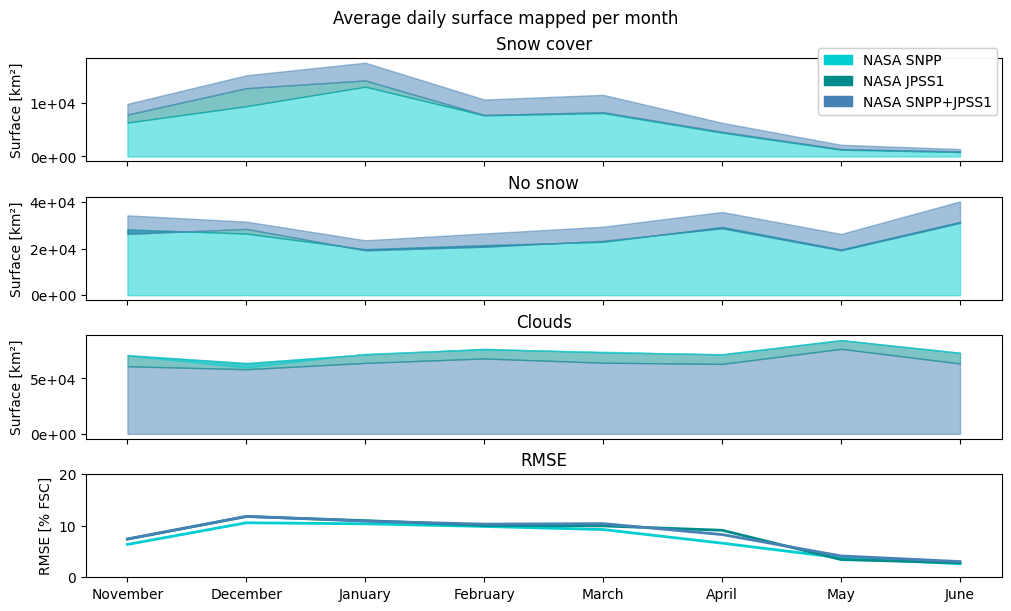

In [35]:
from matplotlib import font_manager, ticker
from postprocess.lps_plots import annual_area_fancy_plot
from typing import Any, Dict, List, Tuple

import matplotlib.pyplot as plt

import xarray as xr

from products.plot_settings import (
    NASA_L3_JPSS1_VAR_NAME,
    NASA_L3_MULTIPLATFORM_VAR_NAME,
    NASA_L3_SNPP_VAR_NAME)

def annual_area_fancy_plot(metrics_dict_completeness: Dict[str, xr.Dataset], metrics_dict_uncertainty: Dict[str, xr.Dataset],axs: List[Axes]| None = None):
    if len(metrics_dict_completeness) > 1:
        common_days = np.intersect1d(*[v.coords["time"] for v in metrics_dict_completeness.values()][:2])

    if len(metrics_dict_completeness) > 2:
        for v in metrics_dict_completeness.values():
            common_days = np.intersect1d(common_days, v.coords["time"])
    if axs is None: 
        _, axs = plt.subplots(4, 1, figsize=(10, 6), sharex=True, layout="constrained")

    [ax.set_ylabel("Surface [km²]", fontproperties=font_manager.FontProperties(size=10)) for ax in axs[:3]]
    axs[3].set_ylabel("RMSE [% FSC]", fontproperties=font_manager.FontProperties(size=10))
    custom_leg = [
        mpatches.Patch(color=PRODUCT_PLOT_COLORS[product_name], label=PRODUCT_PLOT_NAMES[product_name])
        for product_name in metrics_dict_completeness
    ]
    product_legend = axs[0].legend(handles=custom_leg, loc=[0.8, 0.45])
    axs[0].add_artist(product_legend)
    old_snow_cover, old_no_snow, old_clouds = 0, 0, 0
    for product in metrics_dict_completeness:
        metrics_dict_completeness[product] = metrics_dict_completeness[product].sel(time=common_days)
        product_monthly_averages = (
            metrics_dict_completeness[product].resample({"time": "1ME"}).mean(dim="time").data_vars["surface"] * 1e-6
        )

        snow_cover = product_monthly_averages.sel(class_name="snow_cover")
        axs[0].fill_between(
            np.arange(product_monthly_averages.sizes["time"]),
            snow_cover,
            old_snow_cover,
            alpha=0.5,
            color=PRODUCT_PLOT_COLORS[product],
        )
        old_snow_cover = snow_cover
        no_snow = product_monthly_averages.sel(class_name="no_snow")
        axs[1].fill_between(
            np.arange(product_monthly_averages.sizes["time"]),
            no_snow,
            old_no_snow,
            alpha=0.5,
            color=PRODUCT_PLOT_COLORS[product],
        )
        old_no_snow = no_snow

        axs[3].plot(
            np.arange(product_monthly_averages.sizes["time"]),
            metrics_dict_uncertainty[product].rmse,
            color=PRODUCT_PLOT_COLORS[product],
            lw=2,
        )
    axs[0].yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0e}"))
    axs[1].yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0e}"))
    axs[2].yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0e}"))
    axs[3].set_ylim(0, 20)
    for product in [NASA_L3_MULTIPLATFORM_VAR_NAME, NASA_L3_JPSS1_VAR_NAME, NASA_L3_SNPP_VAR_NAME]:
        product_monthly_averages = (
            metrics_dict_completeness[product].resample({"time": "1ME"}).mean(dim="time").data_vars["surface"] * 1e-6
        )
        clouds = product_monthly_averages.sel(class_name="clouds")
        axs[2].fill_between(
            np.arange(product_monthly_averages.sizes["time"]),
            clouds,
            old_clouds,
            alpha=0.5,
            color=PRODUCT_PLOT_COLORS[product],
        )
        old_clouds = clouds
    axs[2].set_xticks(np.arange(product_monthly_averages.sizes["time"]))
    axs[2].set_xticklabels(product_monthly_averages.coords["time"].to_dataframe().index.strftime("%B"))
    axs[0].set_title("Snow cover")
    axs[1].set_title("No snow")
    axs[2].set_title("Clouds")
    axs[3].set_title("RMSE")

    plt.show()

fig, axs = plt.subplots(4, 1, figsize=(10, 6), sharex=True, layout="constrained")
fig.suptitle("Average daily surface mapped per month")
annual_area_fancy_plot(metrics_dict_completeness=metrics_dict_completeness,metrics_dict_uncertainty=metrics_dict_unc, axs=axs)
fig.patch.set_alpha(0.0)
fig.savefig('/home/imperatoren/work/VIIRS_S2_comparison/lps/poster/illustrations/area_composite.png', format='png')

In [32]:
nasa_l3_snpp_metrics_ds.sel(ref_bins=slice(1,99), test_bins=slice(1,99)).sum()

<xarray.Dataset> Size: 8B
Dimensions:        ()
Data variables:
    n_occurrences  float64 8B 7.105e+05

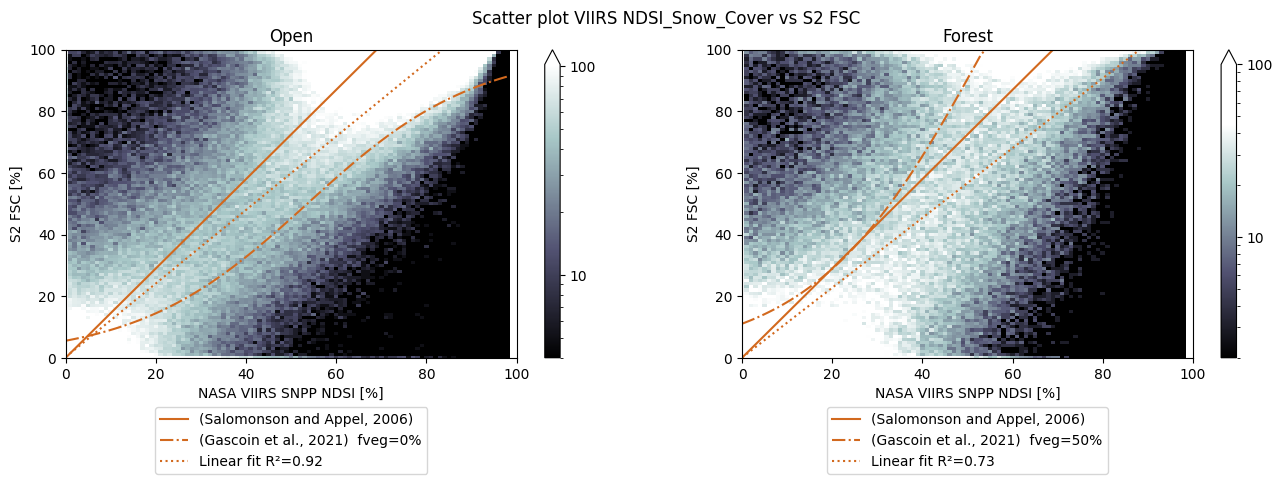

In [12]:

### NDSI-FSC regression
from matplotlib import cm, colors
from matplotlib.axes import Axes
from matplotlib.figure import Figure
from fractional_snow_cover import gascoin, salomonson_appel
from postprocess.scatter_plot import fancy_scatter_plot, fit_regression
from scipy.ndimage import gaussian_filter
import matplotlib.colors as mcolors
import xarray as xr
import matplotlib.pyplot as plt

analysis_type = "scatter"
analysis_folder = (
    "/home/imperatoren/work/VIIRS_S2_comparison/viirsnow/output_folder/version_6_lps/analyses/"
)
nasa_l3_snpp_metrics_ds = xr.open_dataset(
    f"{analysis_folder}/{analysis_type}/{analysis_type}_WY_2023_2024_nasa_l3_snpp_NDSI_vs_s2_theia_FSC.nc", decode_cf=True
)
nasa_l3_snpp_metrics_ds = nasa_l3_snpp_metrics_ds.where(nasa_l3_snpp_metrics_ds > 0, drop=True)

fig, ax = plt.subplots(1,2,figsize=(16 , 4))
plt.style.use('default')
# ax[0].set_facecolor('#222')
FOREST_TITLE = {'no_forest': 'Open', 'forest': 'Forest'}
for i, fore in enumerate(["no_forest", "forest"]):

    n_min = 0
    fig.suptitle("Scatter plot VIIRS NDSI_Snow_Cover vs S2 FSC")
    reduced = (
        nasa_l3_snpp_metrics_ds.sel(
            ref_bins=slice(0, 99),
            forest_mask_bins=[fore],
            test_bins=slice(0, 99),
        )
        .sum(dim=("forest_mask_bins", "time"))
        .data_vars["n_occurrences"]
    )
    xax = reduced.test_bins.values
    f_veg=0 if fore=="no_forest" else 0.5
    fit_g = gascoin(xax * 0.01, f_veg=f_veg) * 100
    ax[i].plot(xax, salomonson_appel(xax), color="chocolate", linewidth=1.5, label="(Salomonson and Appel, 2006)")
    ax[i].plot(xax, fit_g,"-.",color="chocolate", linewidth=1.5, label=f"(Gascoin et al., 2021)  fveg={int(f_veg*100)}%")

    scatter_plot = fancy_scatter_plot(
        data_to_plt=reduced.rename({"ref_bins": "y", "test_bins": "x"}),
        ax=ax[i],
        figure=fig,
        low_threshold=n_min,
        smoothing_window_size=0,
    )
    # ax[i].set_title(PRODUCT_PLOT_NAMES[k])
    ax[i].set_ylabel("S2 FSC [%]")
    ax[i].set_xlabel("NASA VIIRS SNPP NDSI [%]")
    ax[i].set_title(FOREST_TITLE[fore])


plt.show()

fig.patch.set_alpha(0.0)
fig.savefig('/home/imperatoren/work/VIIRS_S2_comparison/lps/poster/illustrations/scatter.png', format='png',bbox_inches='tight')

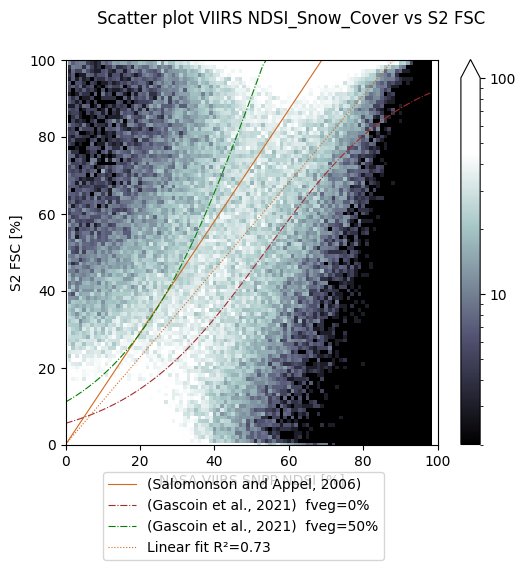

In [221]:

### NDSI-FSC regression
from matplotlib import cm, colors
from matplotlib.axes import Axes
from matplotlib.figure import Figure
from fractional_snow_cover import gascoin, salomonson_appel
from postprocess.scatter_plot import fancy_scatter_plot, fit_regression
from scipy.ndimage import gaussian_filter
import matplotlib.colors as mcolors

def fancy_scatter_plot(
    data_to_plt: xr.DataArray,
    ax: Axes,
    figure: Figure,
    low_threshold: int | None = None,
    smoothing_window_size: int | None = 2,
):
    data_to_plt = data_to_plt.transpose("y", "x")
    if low_threshold is not None:
        data_to_plt = data_to_plt.where(data_to_plt >= low_threshold, 0)
    if smoothing_window_size is not None:
        data_smooth = gaussian_filter(data_to_plt, sigma=smoothing_window_size)
    else:
        # That's ugly
        data_smooth = data_to_plt
    
    coeff_slope, intercept, score = fit_regression(data_to_plt)
    distr_min, distr_max = np.quantile(data_smooth, 0.20), np.quantile(data_smooth, 0.90)
    scatter_plot = ax.pcolormesh(
        data_to_plt.coords["x"].values,
        data_to_plt.coords["y"].values,
        data_smooth,
        norm=colors.LogNorm(vmin=distr_min if distr_min > 0 else 1, vmax=distr_max,clip=True),
        cmap=cm.bone,
    )
    regression_x_axis = np.arange(0, 100)
    ax.plot(
        regression_x_axis,
        regression_x_axis * coeff_slope + intercept,
        ":",
        lw=0.8,
        color="chocolate",
        label=f"Linear fit R²={score:.2f}",  # m={float(coeff_slope):.2f} b={float(intercept):.2f}",
    )
    # ax.plot(regression_x_axis, regression_x_axis, color="k", linewidth=0.5, label="y=x")
    ax.grid(False)
    ax.legend(loc=(0.1,-0.3))
    ax.set_ylim(0, 100)
    ax.set_xlim(0, 100)

    cbar = figure.colorbar(scatter_plot,extend='max')
    cbar_ticks = np.array([ 1e1, 1e2])
    cbar_labels = [f"{tick:n}" for tick in cbar_ticks]
    cbar.set_ticks(cbar_ticks, labels=cbar_labels)
    return scatter_plot
fig, ax = plt.subplots(1,1,figsize=(6 , 5))
plt.style.use('default')
n_min = 0
fig.suptitle("Scatter plot VIIRS NDSI_Snow_Cover vs S2 FSC")
reduced = (
    nasa_l3_snpp_metrics_ds.sel(
        ref_bins=slice(0, 99),
        forest_mask_bins=[fore],
        test_bins=slice(0, 99),
    )
    .sum(dim=("forest_mask_bins", "time"))
    .data_vars["n_occurrences"]
)
xax = reduced.test_bins.values

ax.plot(xax, salomonson_appel(xax), color="chocolate", linewidth=.8, label="(Salomonson and Appel, 2006)")
f_veg=0
fit_g = gascoin(xax * 0.01, f_veg=f_veg) * 100
ax.plot(xax, fit_g,"-.",color="brown", linewidth=.8, label=f"(Gascoin et al., 2021)  fveg={int(f_veg*100)}%")
f_veg=0.5
fit_g = gascoin(xax * 0.01, f_veg=f_veg) * 100
ax.plot(xax, fit_g,"-.",color="green", linewidth=.8, label=f"(Gascoin et al., 2021)  fveg={int(f_veg*100)}%")

scatter_plot = fancy_scatter_plot(
    data_to_plt=reduced.rename({"ref_bins": "y", "test_bins": "x"}),
    ax=ax,
    figure=fig,
    low_threshold=n_min,
    smoothing_window_size=0,
)
# ax[i].set_title(PRODUCT_PLOT_NAMES[k])
ax.set_ylabel("S2 FSC [%]")
ax.set_xlabel("NASA VIIRS SNPP NDSI [%]")

plt.show()

NameError: name 'var' is not defined

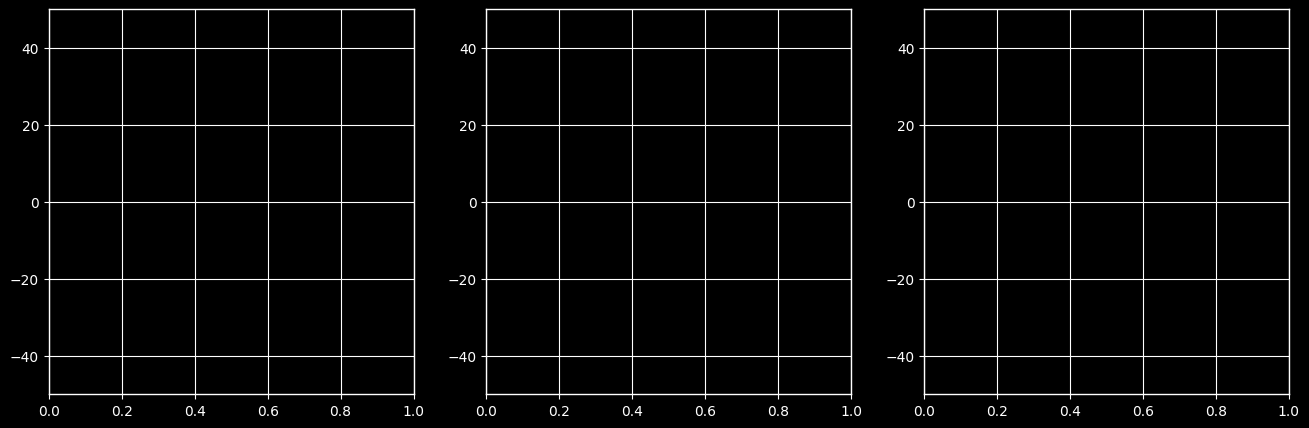

In [67]:

def raw_error_violinplots(metrics_dict: Dict[str, xr.Dataset], analysis_var: str, ax: Axes, **violinplots_kwargs):
    ticks = np.arange(len(list(metrics_dict.values())[0].coords[analysis_var].values))
    for product_name in metrics_dict:
        error_distributions = []


        prod_selected_metrics = metrics_dict[product_name].groupby((analysis_var, 'time')).map()
        error_distributions.append(histograms_to_distribution(prod_selected_metrics))

        product_boxplot = ax.violinplot(
            error_distributions,
            positions=ticks,
            **violinplots_kwargs
            # showextrema=False,
            # points=100,
            # showmeans=True,
            # showmedians=True,
            # quantiles=[[0.1,0.9],[0.1,0.9]]

            # widths=0.2,
            # showfliers=False,
            # patch_artist=True,
            # label=PRODUCT_PLOT_NAMES[product_name],
        )
        for patch in product_boxplot["bodies"]:
            patch.set_facecolor(PRODUCT_PLOT_COLORS[product_name])
        ticks = ticks + 0.2

        print(product_name, value)

    ticks = np.arange(len(list(metrics_dict.values())[0].coords[analysis_var].values))
    ax.set_xticks(ticks + (len(metrics_dict) - 1) * 0.2 / 2)
    ax.grid(True, axis="y")
    ax.legend()

figs, axs = plt.subplots(1,3, figsize=(16, 5))
[ax.set_ylim(-50,50) for ax in axs]
raw_error_violinplots(metrics_dict=metrics_dict_unc,analysis_var=var, ax=axs[0],showextrema=False,points=50,showmeans=True )
raw_error_violinplots(metrics_dict=metrics_dict_unc,analysis_var=var, ax=axs[1],showextrema=False,points=50,bw_method=0.5,showmeans=True )
raw_error_violinplots(metrics_dict=metrics_dict_unc,analysis_var=var, ax=axs[2],showextrema=False,points=50,bw_method=0.1,showmeans=True )
# raw_error_violinplots(metrics_dict=metrics_dict_unc,analysis_var=var, ax=axs[1],showextrema=False,points=100,showmeans=True )
# raw_error_violinplots(metrics_dict=metrics_dict_unc,analysis_var=var, ax=axs[2],showextrema=False,points=200,showmeans=True )

/tmp/ipykernel_27950/3067715573.py:11: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  red = prod_selected_metrics.groupby('biais_bins').sum(list(prod_selected_metrics.dims.keys()))
/tmp/ipykernel_27950/3067715573.py:11: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  red = prod_selected_metrics.groupby('biais_bins').sum(list(prod_selected_metrics.dims.keys()))
/tmp/ipykernel_27950/3067715573.py:11: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimensi

meteofrance_synopsis NW


/tmp/ipykernel_27950/3067715573.py:11: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  red = prod_selected_metrics.groupby('biais_bins').sum(list(prod_selected_metrics.dims.keys()))
/tmp/ipykernel_27950/3067715573.py:11: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  red = prod_selected_metrics.groupby('biais_bins').sum(list(prod_selected_metrics.dims.keys()))
/tmp/ipykernel_27950/3067715573.py:11: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimensi

nasa_l3_snpp NW


/tmp/ipykernel_27950/3067715573.py:11: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  red = prod_selected_metrics.groupby('biais_bins').sum(list(prod_selected_metrics.dims.keys()))
/tmp/ipykernel_27950/3067715573.py:11: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  red = prod_selected_metrics.groupby('biais_bins').sum(list(prod_selected_metrics.dims.keys()))
/tmp/ipykernel_27950/3067715573.py:11: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimensi

nasa_l3_jpss1 NW


/tmp/ipykernel_27950/3067715573.py:40: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


(None,)

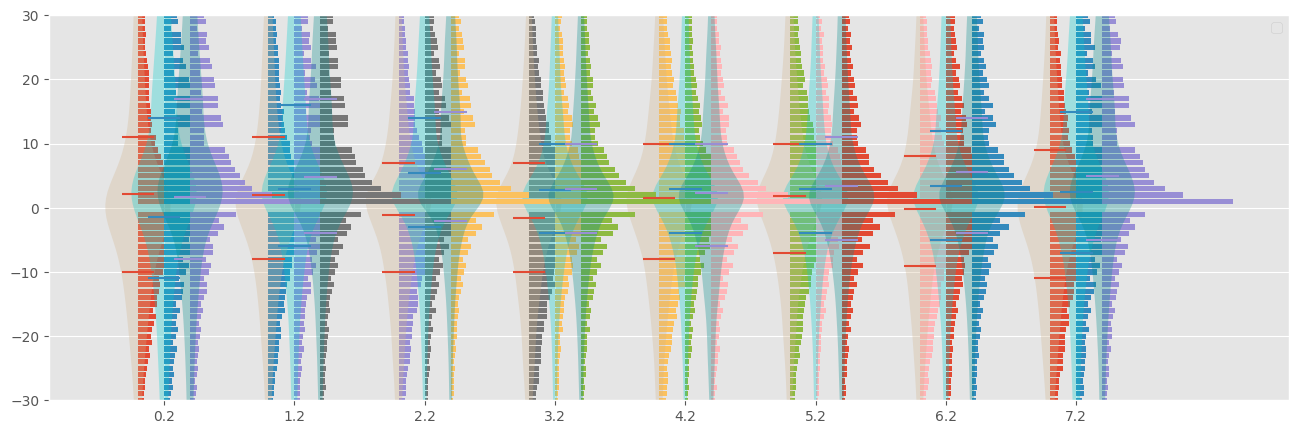

In [143]:
from postprocess.error_distribution import histograms_to_biais_rmse, histograms_to_distribution
from products.plot_settings import PRODUCT_PLOT_COLORS
def raw_error_violinplots(metrics_dict: Dict[str, xr.Dataset], analysis_var: str, ax: Axes, **violinplots_kwargs):
    ticks = np.arange(len(list(metrics_dict.values())[0].coords[analysis_var].values))
    for product_name in metrics_dict:
        error_distributions = []

        for i,value in enumerate(metrics_dict[product_name].coords[analysis_var].values):
            prod_selected_metrics = metrics_dict[product_name].sel({analysis_var: value}).drop_sel(biais_bins=[0])
            error_distributions.append(histograms_to_distribution(prod_selected_metrics))
            red = prod_selected_metrics.groupby('biais_bins').sum(list(prod_selected_metrics.dims.keys()))
            ax.barh(red.biais_bins,width=red.n_occurrences/red.n_occurrences.max(),left=ticks[i])

        product_boxplot = ax.violinplot(
            error_distributions,
            positions=ticks,
            **violinplots_kwargs,
            # showextrema=False,
            # points=100,
            # showmeans=True,
            # showmedians=True,
            quantiles=[[0.25,0.75],[0.25,0.75],[0.25,0.75],[0.25,0.75],[0.25,0.75],[0.25,0.75],[0.25,0.75],[0.25,0.75]]

            # widths=0.2,
            # showfliers=False,
            # patch_artist=True,
            # label=PRODUCT_PLOT_NAMES[product_name],
        )


        for patch in product_boxplot["bodies"]:
            patch.set_facecolor(PRODUCT_PLOT_COLORS[product_name])
        ticks = ticks + 0.2

        print(product_name, value)

    ticks = np.arange(len(list(metrics_dict.values())[0].coords[analysis_var].values))
    ax.set_xticks(ticks + (len(metrics_dict) - 1) * 0.2 / 2)
    ax.grid(True, axis="y")
    ax.legend()

figs, axs = plt.subplots(1,1, figsize=(16, 5))
# figs.style.use('ggplot')
# [axs[0].set_ylim(-50,50) for ax in axs]
axs.set_ylim(-30,30)
raw_error_violinplots(metrics_dict=metrics_dict_unc,analysis_var='aspect_bins', ax=axs,showextrema=False,points=200,showmeans=True),#quantiles=[[0.1,0.9],[0.1,0.9],[0.1,0.9],[0.1,0.9],[0.1,0.9]])
# raw_error_violinplots(metrics_dict=metrics_dict_unc,analysis_var=var, ax=axs[1],showextrema=False,points=200,bw_method=0.5,showmeans=True )
# raw_error_violinplots(metrics_dict=metrics_dict_unc,analysis_var=var, ax=axs[2],showextrema=False,points=200,bw_method=0.1,showmeans=True )
# raw_error_violinplots(metrics_dict=metrics_dict_unc,analysis_var=var, ax=axs[1],showextrema=False,points=100,showmeans=True )
# raw_error_violinplots(metrics_dict=metrics_dict_unc,analysis_var=var, ax=axs[2],showextrema=False,points=200,showmeans=True )

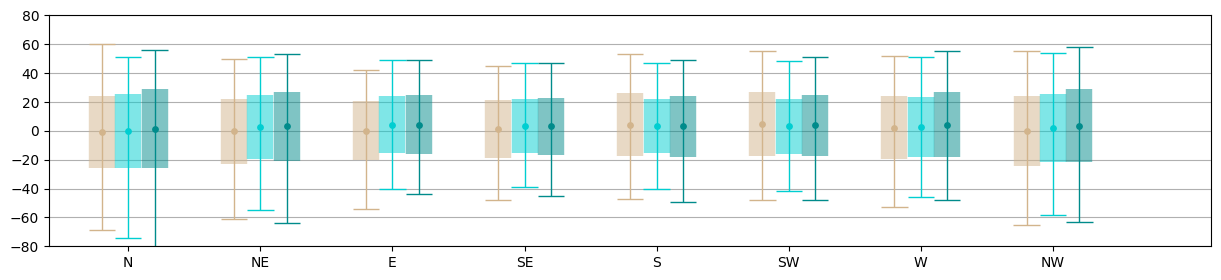

In [ ]:
from typing import Any
import numpy as np
from postprocess.error_distribution import histograms_to_biais_rmse, histograms_to_distribution
from products.plot_settings import PRODUCT_PLOT_COLORS
def smooth_data_np_convolve(arr, span):
    return np.convolve(arr, np.ones(span * 2 + 1) / (span * 2 + 1), mode="same")
# red = metrics_dict_unc['meteofrance_synopsis'].sel(aspect_bins='S')

def linewidth_from_data_units(linewidth, axis, reference='y'):
    """
    Convert a linewidth in data units to linewidth in points.

    Parameters
    ----------
    linewidth: float
        Linewidth in data units of the respective reference-axis
    axis: matplotlib axis
        The axis which is used to extract the relevant transformation
        data (data limits and size must not change afterwards)
    reference: string
        The axis that is taken as a reference for the data width.
        Possible values: 'x' and 'y'. Defaults to 'y'.

    Returns
    -------
    linewidth: float
        Linewidth in points
    """
    fig = axis.get_figure()
    if reference == 'x':
        length = fig.bbox_inches.width * axis.get_position().width
        value_range = np.diff(axis.get_xlim())
    elif reference == 'y':
        length = fig.bbox_inches.height * axis.get_position().height
        value_range = np.diff(axis.get_ylim())
    # Convert length to points
    length *= 72
    # Scale linewidth to value range
    return linewidth * (length / value_range)




def plot_custom_violin(metrics_dict: Dict[str, xr.Dataset],analysis_var: str,  ax :plt.Axes):
    
    x_positions = np.arange(len(list(metrics_dict.values())[0].coords[analysis_var].values))
    x_positions = x_positions/len(x_positions)
    ax.set_ylim(-80,80)
    ax.set_xlim(-0.05,1.05)
    for product_name, metrics_dataset in metrics_dict.items():
        
        color = PRODUCT_PLOT_COLORS[product_name]
        analysis_coords = metrics_dict[product_name].coords[analysis_var].values
        box_width_data = 0.2/len(x_positions)
        fig = ax.get_figure()
        w = fig.bbox_inches.width* ax.get_position().width
        value_range = np.diff(ax.get_xlim())
        box_width_points = box_width_data * (72*w/value_range)
        # print(linewidth_from_data_units(box_width_data,ax,'y'))
        for idx, value in enumerate(analysis_coords):
            x_pos = x_positions[idx]
            product_analysis_var_dataset=  metrics_dataset.sel({analysis_var: value}).drop_sel(biais_bins=0)
            reduced =product_analysis_var_dataset.groupby('biais_bins').sum(list(product_analysis_var_dataset.sizes.keys()))
            smooth = smooth_data_np_convolve(reduced.data_vars['n_occurrences'], 1)
            smooth = smooth/smooth.max() 


            biais_rmse = histograms_to_biais_rmse(reduced)
            distr = histograms_to_distribution(reduced)
            ax.scatter(x_pos, biais_rmse.data_vars['biais'], marker='o', color=color, s=15,zorder=3)

            whiskers_min=np.quantile(distr,0.02)
            whiskers_max=np.quantile(distr,0.98)
            ax.vlines(x_pos, whiskers_min, whiskers_max, color=color, linestyle='-', lw=1)
            ax.vlines(x_pos, biais_rmse.biais-biais_rmse.rmse, biais_rmse.biais+biais_rmse.rmse, color=color, linestyle='-', lw=box_width_points,alpha=0.5)

            ax.hlines(whiskers_min, x_pos-box_width_data/2, x_pos+box_width_data/2, color=color, lw=1)
            ax.hlines(whiskers_max, x_pos-box_width_data/2,x_pos+box_width_data/2, color=color, lw=1)
        x_positions = x_positions+box_width_data
    
    ax.set_xticks(x_positions - box_width_data*((len(metrics_dict)+1)//2), labels=analysis_coords)
    # ax.set_xticklabels()


fig, ax = plt.subplots(figsize=(15,3))


metrics_dict_unc_new = {k: v.sel(ref_bins=slice(None, 101)) for k,v in metrics_dict_unc.items()}
ax.grid(axis='y')
plot_custom_violin(metrics_dict=metrics_dict_unc_new, analysis_var='aspect_bins',ax=ax)

# ticks = []
# selection = metrics_dict_unc['meteofrance_synopsis'].sel(ref_bins=slice(None, 101))
# for i, b in enumerate(selection.ref_bins):
#     plot_custom_violin(ds = selection.sel(ref_bins=b), ax=ax,x_pos=i*3)
#     ticks.append(i*3)
# ax.set_xticks(ticks)
# ax.set_xticklabels(selection.ref_bins.values)



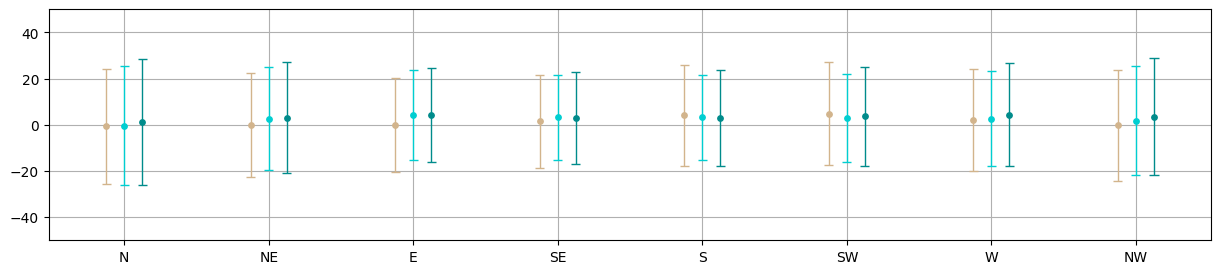

In [6]:
from typing import Any
import numpy as np
from postprocess.error_distribution import histograms_to_biais_rmse, histograms_to_distribution
from products.plot_settings import PRODUCT_PLOT_COLORS
def smooth_data_np_convolve(arr, span):
    return np.convolve(arr, np.ones(span * 2 + 1) / (span * 2 + 1), mode="same")
# red = metrics_dict_unc['meteofrance_synopsis'].sel(aspect_bins='S')

def plot_custom_violin(metrics_dict: Dict[str, xr.Dataset],analysis_var: str,  ax :plt.Axes):
    x_positions = np.arange(8*len(list(metrics_dict.values())[0].coords[analysis_var].values),step=8)
    for product_name, metrics_dataset in metrics_dict.items():
        
        color = PRODUCT_PLOT_COLORS[product_name]
        analysis_coords = metrics_dict[product_name].coords[analysis_var].values
        for idx, value in enumerate(analysis_coords):
            x_pos = x_positions[idx]
            product_analysis_var_dataset=  metrics_dataset.sel({analysis_var: value}).drop_sel(biais_bins=0)
            reduced =product_analysis_var_dataset.groupby('biais_bins').sum(list(product_analysis_var_dataset.sizes.keys()))
            smooth = smooth_data_np_convolve(reduced.data_vars['n_occurrences'], 1)
            smooth = smooth/smooth.max() 

            # ax.fill_betweenx(reduced.coords['biais_bins'],x_pos,x_pos+smooth,color=color, alpha=0.25)
            # ax.plot(x_pos+smooth, reduced.coords['biais_bins'],color=color,lw=0.5)
            # ax.fill_betweenx( reduced.coords['biais_bins'],x_pos, x_pos-smooth,color=color, alpha=0.25)
            # ax.plot(x_pos-smooth, reduced.coords['biais_bins'],color=color,lw=0.5)

            biais_rmse = histograms_to_biais_rmse(reduced)
            distr = histograms_to_distribution(reduced)
            # ax.vlines(x_pos, np.quantile(distr,0.05), np.quantile(distr,0.95), color=color, linestyle='-',alpha=0.5, lw=5)
            ax.scatter(x_pos, biais_rmse.data_vars['biais'], marker='o', color=color, s=15,zorder=3)

            # whiskers_min=reduced.where(reduced.data_vars['n_occurrences']>0,drop=True).coords['biais_bins'].min()
            # whiskers_max=reduced.where(reduced.data_vars['n_occurrences']>0,drop=True).coords['biais_bins'].max()
            whiskers_min=biais_rmse.biais - biais_rmse.rmse
            whiskers_max=biais_rmse.biais + biais_rmse.rmse
            ax.vlines(x_pos, whiskers_min, whiskers_max, color=color, linestyle='-', lw=1)
            ax.hlines(whiskers_min, x_pos-0.25, x_pos+0.25, color=color, lw=1)
            ax.hlines(whiskers_max, x_pos-0.25,x_pos+ 0.25, color=color, lw=1)
        x_positions = x_positions+1
    ax.set_ylim(-50,50)
    ax.set_xticks(x_positions - 1*((len(metrics_dict)+1)//2))
    ax.set_xticklabels(analysis_coords)


fig, ax = plt.subplots(figsize=(15,3))


metrics_dict_unc_new = {k: v.sel(ref_bins=slice(None, 101)) for k,v in metrics_dict_unc.items()}
plot_custom_violin(metrics_dict=metrics_dict_unc_new, analysis_var='aspect_bins',ax=ax)
ax.grid('y')
# ticks = []
# selection = metrics_dict_unc['meteofrance_synopsis'].sel(ref_bins=slice(None, 101))
# for i, b in enumerate(selection.ref_bins):
#     plot_custom_violin(ds = selection.sel(ref_bins=b), ax=ax,x_pos=i*3)
#     ticks.append(i*3)
# ax.set_xticks(ticks)
# ax.set_xticklabels(selection.ref_bins.values)

